In [386]:
import warnings
import math
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    RandomizedSearchCV,
)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import xgboost as xgb
import shap
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [387]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### filter max and min of ros_p

In [388]:
#df = df[df["ros_p"] < 3000]
#df = df[df["ros_p"] > 500]

### remove nans from ros_p

In [389]:
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### convert categorical variables into "category" type

In [390]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [391]:
log_base = 10

ros_lag_cols = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in ros_lag_cols:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=ros_lag_cols, inplace=True)

### Select specific columns for modeling

In [392]:
c = [
    "ros_p",
    "gp_300_av",
    "wv100_k_av",
    "wv_950_av",
    "sP_hPa_av",
    "HDW_av",
    "wv10_kh_av",
    "gp_500_av",
    "gp_850_av",
    "TotCC_p_av",
    "gp_m2s2_av"
]

df = df[c]

### Eliminate vars with >50% rows with nans

In [393]:
df = df.drop(
    columns=["EL_m_av", "Cin_av", "gT_s_9_av", "rh_700_av", "LiftIdx_av", "CBH_m_av"],
    errors="ignore"
)


### Linear Model

In [394]:
param_dist = {
    'model__alpha': uniform(0.001, 10),               # Regularization strength
    'model__fit_intercept': [True, False],            # Whether to calculate intercept
    'model__max_iter': [1000, 2000, 5000],           # Maximum iterations
    'model__tol': [1e-4, 1e-5, 1e-6],               # Tolerance for stopping
}

# Ridge regression pipeline
base_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # Handle NaN values
    ('scaler', StandardScaler()),                     # Scale features
    ('model', Ridge(random_state=42))                 # Your linear model
])

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Halving random search
linear_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,                                         # how aggressively to cut poor performers
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

### train and test datasets

In [395]:
# Define features (excluding specific columns)

train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]
# Create initial X and y
X = df[train_features].copy()
y = df['ros_p'].copy()


# Remove invalid targets (-1) BEFORE cross-validation 

valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

Total valid samples for Cross-Validation: 1173


### model training

In [396]:
# Add more robust data checking and preprocessing
from sklearn.preprocessing import RobustScaler

# 1. Check for problematic values BEFORE transformation
print("Checking for NaN in X:", X.isna().sum().sum())
print("Checking for Inf in X:", np.isinf(X.select_dtypes(include=[np.number])).sum().sum())
print("Y value range:", y.min(), "to", y.max())

# 2. Check after log transformation
log_mult = 1
log_base = 10
y_log = log_mult * np.log1p(y) / np.log(log_base)

print("Y_log value range:", y_log.min(), "to", y_log.max())
print("NaN in y_log:", np.isnan(y_log).sum())
print("Inf in y_log:", np.isinf(y_log).sum())

# 3. Replace Inf values if they exist
if np.isinf(y_log).any():
    y_log = np.where(np.isinf(y_log), np.nan, y_log)
    y_log = pd.Series(y_log).fillna(y_log[~np.isnan(y_log)].median()).values

param_dist = {
    'model__alpha': uniform(0.001, 10),               # Regularization strength
    'model__fit_intercept': [True, False],            # Whether to calculate intercept
    'model__max_iter': [1000, 2000, 5000],           # Maximum iterations
    'model__tol': [1e-4, 1e-5, 1e-6],               # Tolerance for stopping
}

# Ridge regression pipeline
base_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # Handle NaN values
    ('scaler', StandardScaler()),                     # Scale features
    ('model', Ridge(random_state=42))                 # Your linear model
])

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Halving random search with more resources
linear_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,                                         # how aggressively to cut poor performers
    resource='n_samples',                          
    min_resources=100,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)


Checking for NaN in X: 0
Checking for Inf in X: 0
Y value range: 16.983145 to 8949.2005
Y_log value range: 1.2548656460570582 to 3.9518327643738207
NaN in y_log: 0
Inf in y_log: 0


In [397]:
log_mult = 1 #23.3139 
log_base = 10 #2.9637

y_log = log_mult *  np.log1p(y) / np.log(log_base)

# Train the model search 
linear_random.fit(
    X, 
    y_log
)

# 5. RESULT
print("\nBest Cross-Validation Score (R2):", linear_random.best_score_)

print("Trained on full dataset. Best model saved.")

final_model = linear_random.best_estimator_
import joblib

joblib.dump(final_model, "../../Data/Models/Linear.pkl")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 1173
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 11
n_resources: 100
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 1
n_candidates: 6
n_resources: 200
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Cross-Validation Score (R2): 0.2951278477249427
Trained on full dataset. Best model saved.


['../../Data/Models/Linear.pkl']

### debugging


Processing Fold 1
  Train size: 938
  Test size:  235
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 938
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 100
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete for Fold 1
Best parameters found: {'model__alpha': np.float64(1.5609452033620264), 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__tol': 0.0001}

Log scale metrics:
R2 Score (log): 0.3698
RMSE (log): 0.3538 (linear: 888.0)
MAE (log): 0.2802 (linear: 488.8)


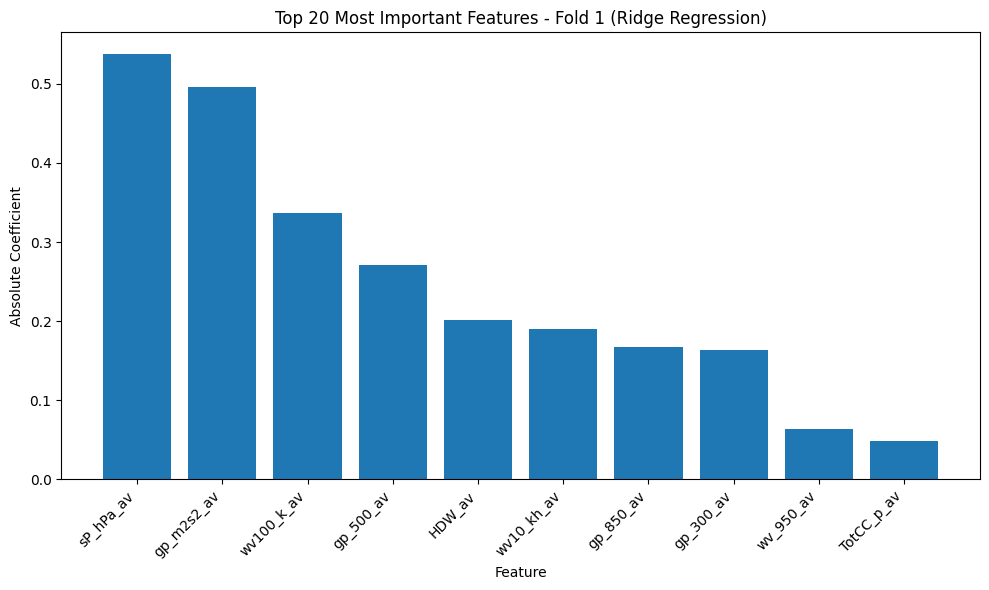


Top 20 Most Important Features (Fold 1):
      feature  coefficient  abs_coefficient
3   sP_hPa_av    -0.538200         0.538200
9  gp_m2s2_av    -0.496518         0.496518
1  wv100_k_av     0.337353         0.337353
6   gp_500_av    -0.271520         0.271520
4      HDW_av     0.201681         0.201681
5  wv10_kh_av    -0.190282         0.190282
7   gp_850_av     0.167797         0.167797
0   gp_300_av     0.164016         0.164016
2   wv_950_av    -0.063819         0.063819
8  TotCC_p_av     0.049010         0.049010


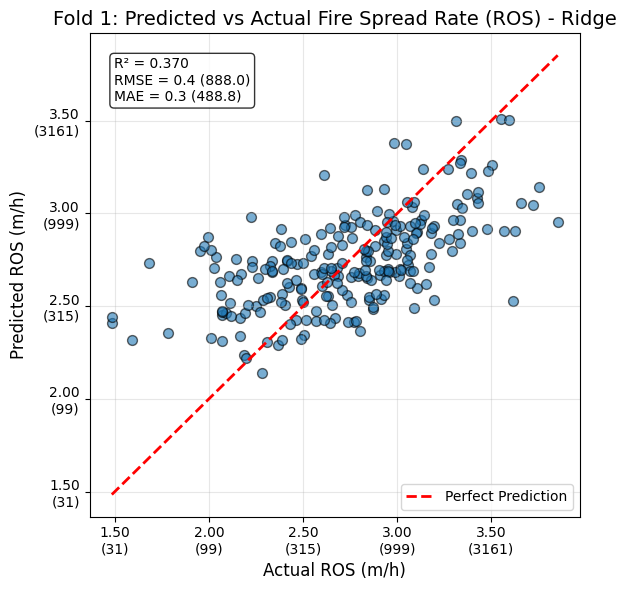


Processing Fold 2
  Train size: 938
  Test size:  235
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 938
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 100
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete for Fold 2
Best parameters found: {'model__alpha': np.float64(1.5609452033620264), 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__tol': 0.0001}

Log scale metrics:
R2 Score (log): 0.2779
RMSE (log): 0.3978 (linear: 938.1)
MAE (log): 0.3219 (linear: 541.7)


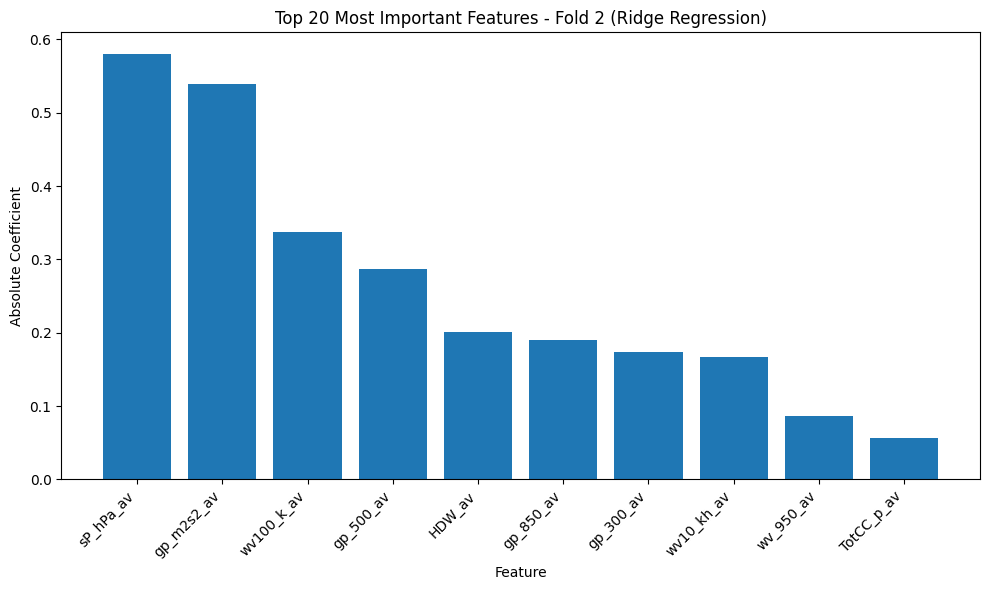


Top 20 Most Important Features (Fold 2):
      feature  coefficient  abs_coefficient
3   sP_hPa_av    -0.580423         0.580423
9  gp_m2s2_av    -0.538529         0.538529
1  wv100_k_av     0.336667         0.336667
6   gp_500_av    -0.287500         0.287500
4      HDW_av     0.200419         0.200419
7   gp_850_av     0.190739         0.190739
0   gp_300_av     0.174013         0.174013
5  wv10_kh_av    -0.167358         0.167358
2   wv_950_av    -0.087039         0.087039
8  TotCC_p_av     0.056476         0.056476


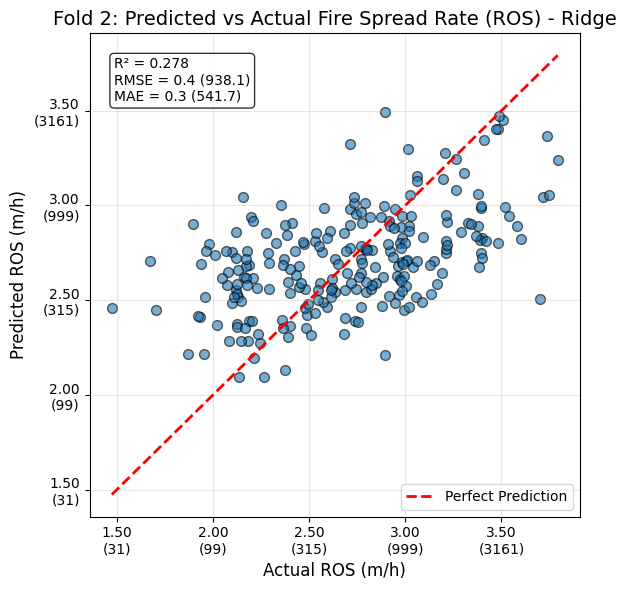


Processing Fold 3
  Train size: 938
  Test size:  235
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 938
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 100
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete for Fold 3
Best parameters found: {'model__alpha': np.float64(1.5609452033620264), 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__tol': 0.0001}

Log scale metrics:
R2 Score (log): 0.3082
RMSE (log): 0.3895 (linear: 1026.4)
MAE (log): 0.3102 (linear: 541.4)


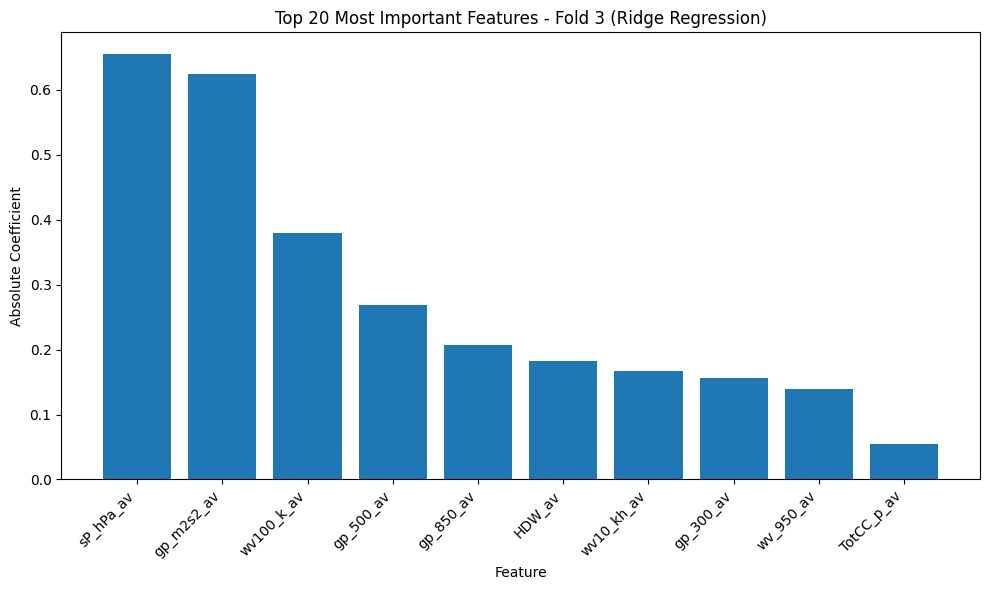


Top 20 Most Important Features (Fold 3):
      feature  coefficient  abs_coefficient
3   sP_hPa_av    -0.655609         0.655609
9  gp_m2s2_av    -0.623669         0.623669
1  wv100_k_av     0.380167         0.380167
6   gp_500_av    -0.268913         0.268913
7   gp_850_av     0.206657         0.206657
4      HDW_av     0.182840         0.182840
5  wv10_kh_av    -0.166307         0.166307
0   gp_300_av     0.156783         0.156783
2   wv_950_av    -0.139683         0.139683
8  TotCC_p_av     0.055235         0.055235


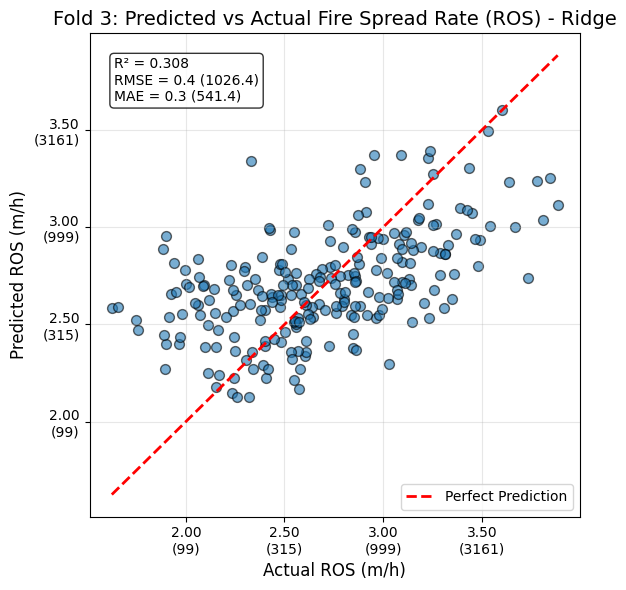


Processing Fold 4
  Train size: 939
  Test size:  234
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 939
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 100
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete for Fold 4
Best parameters found: {'model__alpha': np.float64(1.5609452033620264), 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__tol': 0.0001}

Log scale metrics:
R2 Score (log): 0.3321
RMSE (log): 0.4052 (linear: 1268.6)
MAE (log): 0.3242 (linear: 637.9)


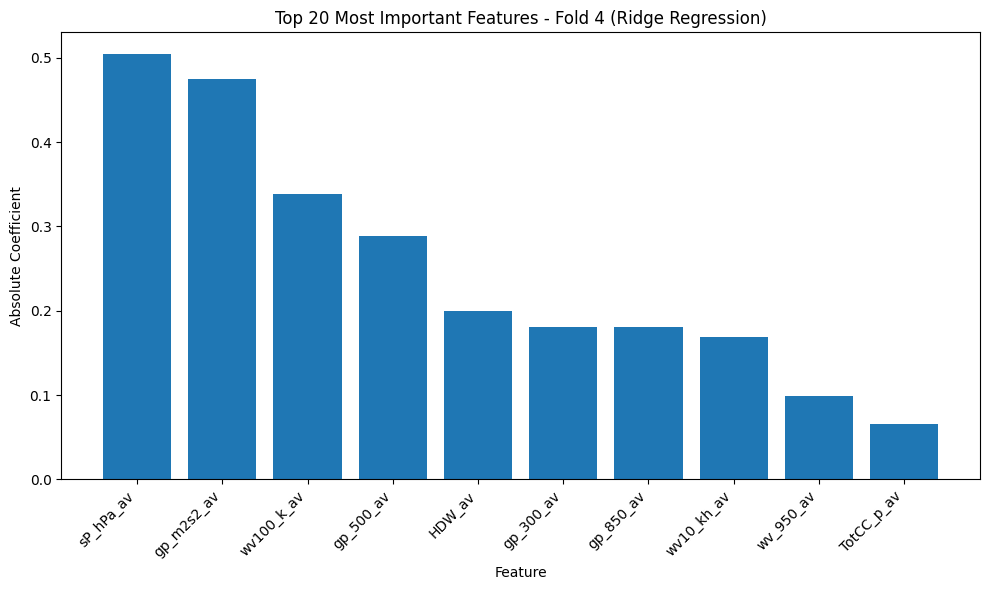


Top 20 Most Important Features (Fold 4):
      feature  coefficient  abs_coefficient
3   sP_hPa_av    -0.504886         0.504886
9  gp_m2s2_av    -0.475028         0.475028
1  wv100_k_av     0.338530         0.338530
6   gp_500_av    -0.288333         0.288333
4      HDW_av     0.199205         0.199205
0   gp_300_av     0.181161         0.181161
7   gp_850_av     0.180762         0.180762
5  wv10_kh_av    -0.169510         0.169510
2   wv_950_av    -0.098450         0.098450
8  TotCC_p_av     0.066250         0.066250


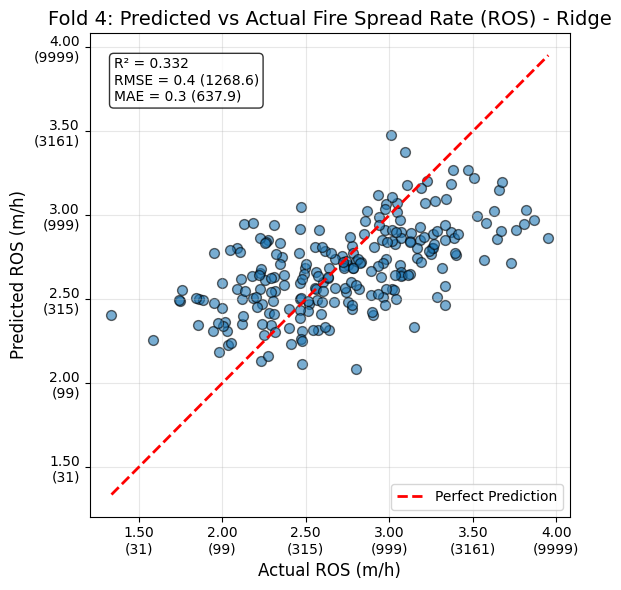


Processing Fold 5
  Train size: 939
  Test size:  234
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 939
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 100
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete for Fold 5
Best parameters found: {'model__alpha': np.float64(1.5609452033620264), 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__tol': 0.0001}

Log scale metrics:
R2 Score (log): 0.2216
RMSE (log): 0.4270 (linear: 849.8)
MAE (log): 0.3364 (linear: 527.3)


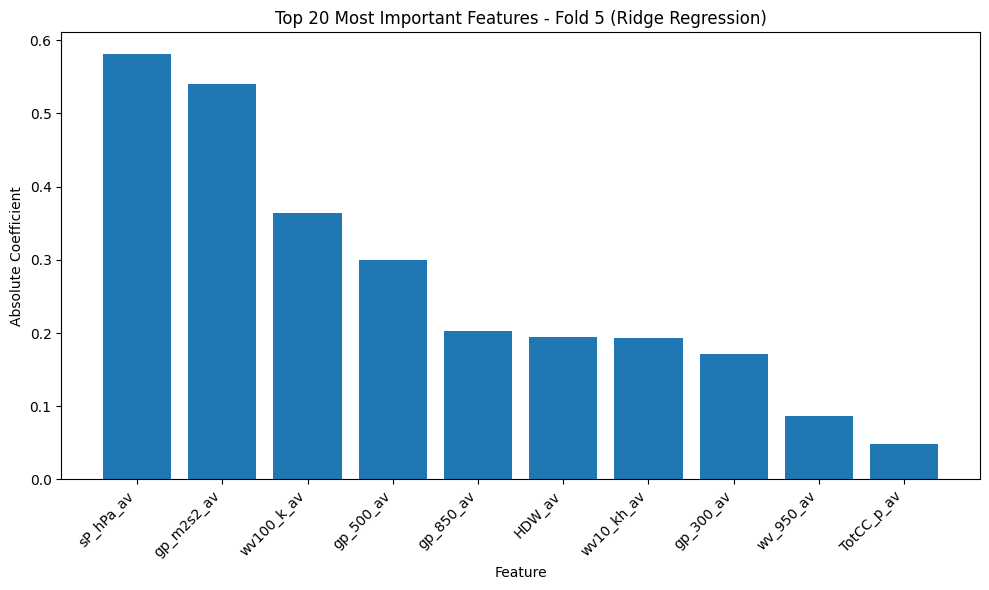


Top 20 Most Important Features (Fold 5):
      feature  coefficient  abs_coefficient
3   sP_hPa_av    -0.581671         0.581671
9  gp_m2s2_av    -0.539588         0.539588
1  wv100_k_av     0.364261         0.364261
6   gp_500_av    -0.299908         0.299908
7   gp_850_av     0.202949         0.202949
4      HDW_av     0.195186         0.195186
5  wv10_kh_av    -0.193110         0.193110
0   gp_300_av     0.171744         0.171744
2   wv_950_av    -0.087373         0.087373
8  TotCC_p_av     0.048337         0.048337


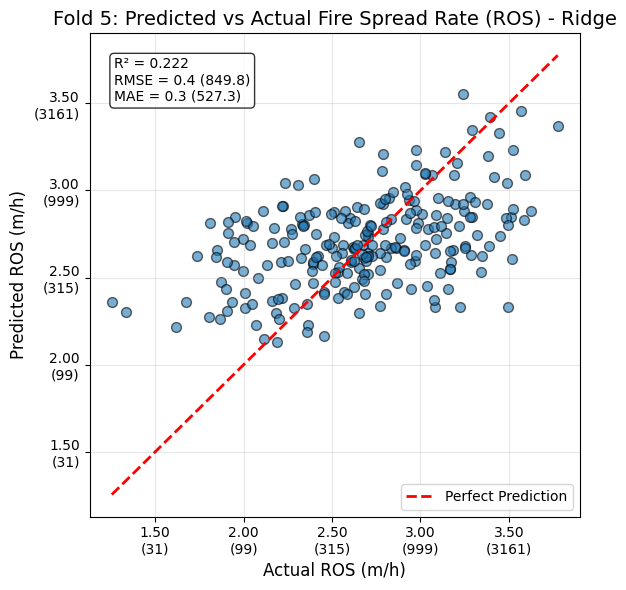


FINAL CROSS-VALIDATION RESULTS (AVERAGED ACROSS ALL FOLDS)

Per-Fold Metrics:
 fold       r2  rmse_log  mae_log  rmse_linear  mae_linear
    1 0.369821  0.353757 0.280172   888.042568  488.774263
    2 0.277926  0.397793 0.321875   938.052988  541.741744
    3 0.308205  0.389533 0.310231  1026.377627  541.363944
    4 0.332093  0.405191 0.324232  1268.556362  637.911097
    5 0.221581  0.427026 0.336408   849.817570  527.334067

------------------------------------------------------------
AVERAGE METRICS:
------------------------------------------------------------
R² Score (log):        0.3019 ± 0.0561
RMSE (log):            0.3947 ± 0.0268
MAE (log):             0.3146 ± 0.0214
RMSE (linear):         994.2 ± 167.0
MAE (linear):          547.4 ± 55.0

------------------------------------------------------------
TOP 20 MOST IMPORTANT FEATURES (AVERAGED COEFFICIENTS):
------------------------------------------------------------
   feature  coefficient  abs_coefficient
 sP_hPa_av    -0.

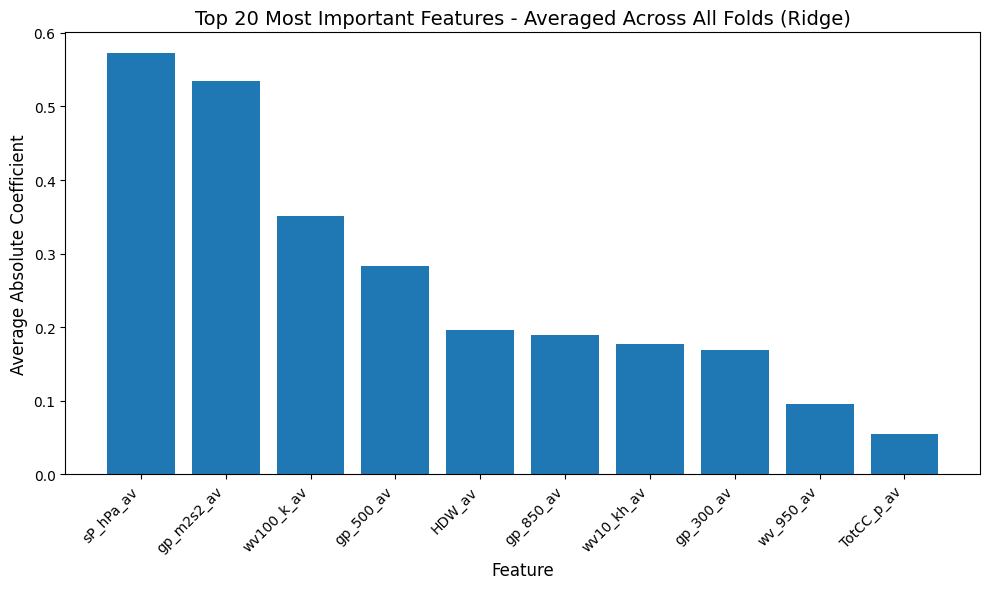


------------------------------------------------------------
OVERALL METRICS (ALL PREDICTIONS COMBINED):
------------------------------------------------------------
R² Score (log):        0.3017
RMSE (log):            0.3953
MAE (log):             0.3146
RMSE (linear):         1005.2
MAE (linear):          547.4


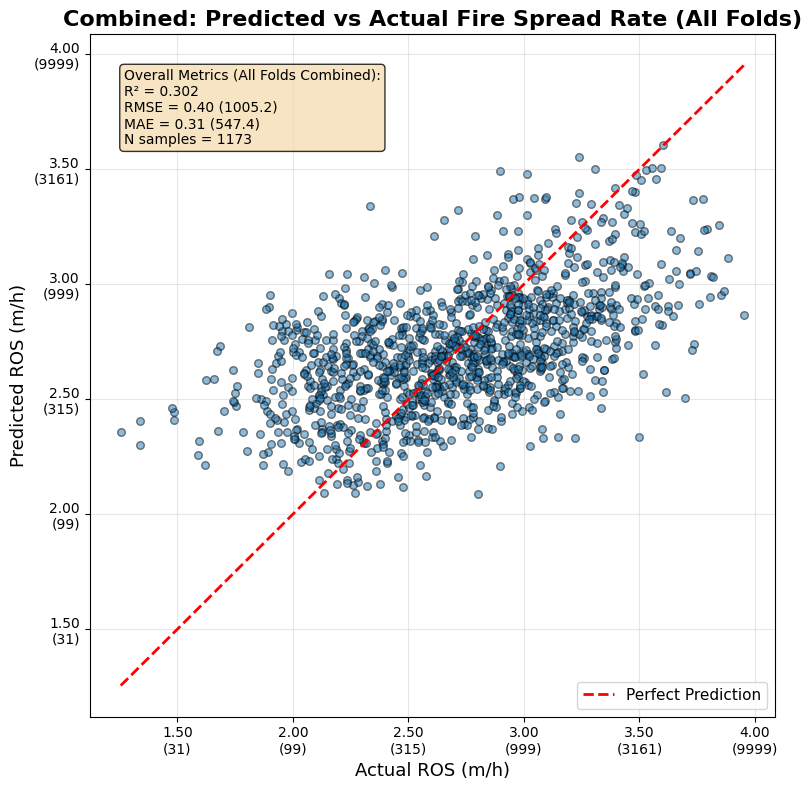


CROSS-VALIDATION COMPLETE


In [398]:
# 4. INITIALIZE TRACKING FOR AVERAGED RESULTS
fold_metrics = []
all_y_test_log = []
all_y_pred_log = []
all_y_test_linear = []
all_y_pred_linear = []
all_coefficients = []

# ========================================
# 5. THE CROSS-VALIDATION LOOP
# ========================================
fold = 1
for train_index, test_index in kf.split(X, y):
    print(f"\n{'='*60}")
    print(f"Processing Fold {fold}")
    print(f"{'='*60}")
    
    # Split the data based on the current fold's indices
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    # Log transformation parameters
    log_mult = 1  # 23.3139 
    log_base = 10  # 2.9637

    y_train_log = log_mult * np.log1p(y_train_final) / np.log(log_base)
    y_test_log = log_mult * np.log1p(y_test_final) / np.log(log_base)

    print(f"  Train size: {len(X_train_final)}")
    print(f"  Test size:  {len(X_test_final)}")
    
    # Train the model search
    linear_random.fit(X_train_final, y_train_log)

    # Get the best model and parameters
    print(f"\nSearch complete for Fold {fold}")
    print(f"Best parameters found: {linear_random.best_params_}")
    best_model = linear_random.best_estimator_

    # Make predictions with the best model
    y_pred_log = best_model.predict(X_test_final)

    # Inverse transform log to linear
    inv_mult = np.log(log_base) / log_mult
    y_test_linear = np.exp(y_test_log * inv_mult) - 1
    y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

    # Metrics in log space
    r2 = r2_score(y_test_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
    mae_log = mean_absolute_error(y_test_log, y_pred_log)

    # Metrics in linear space
    rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
    mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

    # Store metrics for averaging
    fold_metrics.append({
        'fold': fold,
        'r2': r2,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'rmse_linear': rmse_linear,
        'mae_linear': mae_linear
    })

    # Store predictions for combined plot
    all_y_test_log.extend(y_test_log.tolist())
    all_y_pred_log.extend(y_pred_log.tolist())
    all_y_test_linear.extend(y_test_linear.tolist())
    all_y_pred_linear.extend(y_pred_linear.tolist())

    # Feature importance (coefficients for Ridge)
    feature_names = X_train_final.columns.tolist()
    final_model = best_model.named_steps['model']
    
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': final_model.coef_,
        'abs_coefficient': np.abs(final_model.coef_)
    })
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    all_coefficients.append(coefficients)

    print("\nLog scale metrics:")
    print(f"R2 Score (log): {r2:.4f}")
    print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
    print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")

    # Plot feature importance (absolute coefficients)
    plt.figure(figsize=(10, 6))
    plt.bar(coefficients['feature'][:20], coefficients['abs_coefficient'][:20])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 20 Most Important Features - Fold {fold} (Ridge Regression)')
    plt.xlabel('Feature')
    plt.ylabel('Absolute Coefficient')
    plt.tight_layout()
    plt.show()

    print(f"\nTop 20 Most Important Features (Fold {fold}):")
    print(coefficients.head(20))

    # Predicted vs Actual scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

    # Perfect prediction line
    min_val = min(y_test_log.min(), y_pred_log.min())
    max_val = max(y_test_log.max(), y_pred_log.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.title(f'Fold {fold}: Predicted vs Actual Fire Spread Rate (ROS) - Ridge', fontsize=14)
    plt.xlabel('Actual ROS (m/h)', fontsize=12)
    plt.ylabel('Predicted ROS (m/h)', fontsize=12)

    # Add metrics annotation with both log and linear scales
    plt.text(0.05, 0.95, 
        f'R² = {r2:.3f}\n'
        f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
        f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
        transform=plt.gca().transAxes, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # inverse-transform scaling factor
    inv_mult = np.log(log_base) / log_mult

    def tick_formatter_log_to_linear(x, pos):
        """Formats tick: log_value  (linear_value)"""
        linear_val = np.exp(x * inv_mult) - 1
        return f"{x:.2f}\n({linear_val:.0f})"

    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    fold += 1

# ========================================
# 6. FINAL AVERAGED RESULTS
# ========================================
print("\n" + "="*60)
print("FINAL CROSS-VALIDATION RESULTS (AVERAGED ACROSS ALL FOLDS)")
print("="*60)

# Create metrics dataframe
metrics_df = pd.DataFrame(fold_metrics)
print("\nPer-Fold Metrics:")
print(metrics_df.to_string(index=False))

# Calculate averages
avg_metrics = metrics_df.mean(numeric_only=True)
std_metrics = metrics_df.std(numeric_only=True)

print("\n" + "-"*60)
print("AVERAGE METRICS:")
print("-"*60)
print(f"R² Score (log):        {avg_metrics['r2']:.4f} ± {std_metrics['r2']:.4f}")
print(f"RMSE (log):            {avg_metrics['rmse_log']:.4f} ± {std_metrics['rmse_log']:.4f}")
print(f"MAE (log):             {avg_metrics['mae_log']:.4f} ± {std_metrics['mae_log']:.4f}")
print(f"RMSE (linear):         {avg_metrics['rmse_linear']:.1f} ± {std_metrics['rmse_linear']:.1f}")
print(f"MAE (linear):          {avg_metrics['mae_linear']:.1f} ± {std_metrics['mae_linear']:.1f}")

# Average coefficients across all folds
avg_coefficients = pd.concat(all_coefficients).groupby('feature').agg({
    'coefficient': 'mean',
    'abs_coefficient': 'mean'
}).reset_index()
avg_coefficients = avg_coefficients.sort_values('abs_coefficient', ascending=False)

print("\n" + "-"*60)
print("TOP 20 MOST IMPORTANT FEATURES (AVERAGED COEFFICIENTS):")
print("-"*60)
print(avg_coefficients.head(20).to_string(index=False))

# Plot averaged coefficients
plt.figure(figsize=(10, 6))
plt.bar(avg_coefficients['feature'][:20], avg_coefficients['abs_coefficient'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features - Averaged Across All Folds (Ridge)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average Absolute Coefficient', fontsize=12)
plt.tight_layout()
plt.show()

# Convert to numpy arrays for overall metrics
all_y_test_log = np.array(all_y_test_log)
all_y_pred_log = np.array(all_y_pred_log)
all_y_test_linear = np.array(all_y_test_linear)
all_y_pred_linear = np.array(all_y_pred_linear)

# Calculate overall metrics on all predictions combined
overall_r2 = r2_score(all_y_test_log, all_y_pred_log)
overall_rmse_log = np.sqrt(mean_squared_error(all_y_test_log, all_y_pred_log))
overall_mae_log = mean_absolute_error(all_y_test_log, all_y_pred_log)
overall_rmse_linear = np.sqrt(mean_squared_error(all_y_test_linear, all_y_pred_linear))
overall_mae_linear = mean_absolute_error(all_y_test_linear, all_y_pred_linear)

print("\n" + "-"*60)
print("OVERALL METRICS (ALL PREDICTIONS COMBINED):")
print("-"*60)
print(f"R² Score (log):        {overall_r2:.4f}")
print(f"RMSE (log):            {overall_rmse_log:.4f}")
print(f"MAE (log):             {overall_mae_log:.4f}")
print(f"RMSE (linear):         {overall_rmse_linear:.1f}")
print(f"MAE (linear):          {overall_mae_linear:.1f}")

# Final combined scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test_log, all_y_pred_log, alpha=0.5, edgecolor='k', s=30)

# Perfect prediction line
min_val = min(all_y_test_log.min(), all_y_pred_log.min())
max_val = max(all_y_test_log.max(), all_y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Combined: Predicted vs Actual Fire Spread Rate (All Folds)', fontsize=16, fontweight='bold')
plt.xlabel('Actual ROS (m/h)', fontsize=13)
plt.ylabel('Predicted ROS (m/h)', fontsize=13)

# Add metrics annotation
metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'R² = {overall_r2:.3f}\n'
    f'RMSE = {overall_rmse_log:.2f} ({overall_rmse_linear:.1f})\n'
    f'MAE = {overall_mae_log:.2f} ({overall_mae_linear:.1f})\n'
    f'N samples = {len(all_y_test_log)}'
)
plt.text(0.05, 0.95, 
    metrics_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10)

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CROSS-VALIDATION COMPLETE")
print("="*60)

In [399]:
"""from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

# Check for NaN values before proceeding
print(f"NaN values in X_train_final: {X_train_final.isna().sum().sum()}")
print(f"NaN values in y_train_log: {y_train_log.isna().sum() if hasattr(y_train_log, 'isna') else np.isnan(y_train_log).sum()}")
print(f"NaN values in X_test_final: {X_test_final.isna().sum().sum()}")

# Parameter distributions for different models
param_dist = {
    'model__alpha': uniform(0.001, 10),               # Regularization strength
    'model__fit_intercept': [True, False],            # Whether to calculate intercept
    'model__max_iter': [1000, 2000, 5000],           # Maximum iterations
    'model__tol': [1e-4, 1e-5, 1e-6],               # Tolerance for stopping
}

# Option 1: Linear model with imputation
base_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # Handle NaN values
    ('scaler', StandardScaler()),                     # Scale features
    ('model', Ridge(random_state=42))                 # Your linear model
])

# Time series cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Halving random search
linear_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,                                         # how aggressively to cut poor performers
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model search
print("Starting model training...")
linear_random.fit(X_train_final, y_train_log)

# Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {linear_random.best_params_}")
best_model = linear_random.best_estimator_

# Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Inverse transform log to linear
inv_mult = np.log(log_base) / log_mult
y_test_linear = np.exp(y_test_log * inv_mult) - 1
y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

# Metrics in log space
r2 = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)

# Metrics in linear space
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

# Feature importance/coefficients
feature_names = X_train_final.columns.tolist()

# Extract the actual model from the pipeline if using one
if hasattr(best_model, 'named_steps'):
    final_model = best_model.named_steps['model']
else:
    final_model = best_model

if hasattr(final_model, 'coef_'):
    # For linear models (Ridge, Lasso, ElasticNet)
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(final_model.coef_)
    })
    model_type = type(final_model).__name__
elif hasattr(final_model, 'feature_importances_'):
    # For tree-based models like RandomForest
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    })
    model_type = type(final_model).__name__
else:
    # Fallback
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': [1.0] * len(feature_names)
    })
    model_type = "Pipeline with " + type(final_model).__name__

importances = importances.sort_values('importance', ascending=False)

print("\nLog scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features ({model_type})')
plt.tight_layout()
plt.show()

print(f"\nTop 20 Most Important Features ({model_type}):")
print(importances.head(20))

# If using linear model, also show coefficients with signs
if hasattr(final_model, 'coef_'):
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': final_model.coef_,
        'abs_coefficient': np.abs(final_model.coef_)
    })
    coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
    print(f"\nTop 20 Coefficients ({model_type}):")
    print(coefficients.head(20))

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title(f'Predicted vs Actual Fire Spread Rate (ROS) - {model_type}', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation with both log and linear scales
plt.text(0.05, 0.95, 
    f'R² = {r2:.3f}\n'
    f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
    f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()"""

SyntaxError: invalid syntax (1525122435.py, line 164)

### linear equation

In [ ]:
# Simple Linear Equation Output
print("LINEAR EQUATION FOR PREDICTING FIRE SPREAD RATE")
print("=" * 60)

# Get the model and coefficients
if hasattr(best_model, 'named_steps'):
    final_model = best_model.named_steps['model']
    coef = final_model.coef_
    intercept = final_model.intercept_
else:
    final_model = best_model
    coef = final_model.coef_
    intercept = final_model.intercept_

feature_names = X_train_final.columns.tolist()

# Build the equation
equation = f"log(ROS) = {intercept:.4f}"
for i, (c, feature) in enumerate(zip(coef, feature_names)):
    if abs(c) > 0.001:  # Only show meaningful terms
        sign = " + " if c >= 0 else " - "
        equation += f"{sign}{abs(c):.4f}×{feature}"

print(f"\n{equation}")
print(f"\nWhere:")
print(f"- ROS is Rate of Spread (m/h)")
print(f"- All features are in their original units")
print(f"- To get linear ROS: ROS_linear = exp(log(ROS) × {inv_mult:.4f}) - 1")

# Show top 5 most influential features
top_5_idx = np.argsort(np.abs(coef))[-10:][::-1]
print(f"\nTop 10 most influential features:")
for idx in top_5_idx:
    print(f"  {feature_names[idx]}: {coef[idx]:.4f} (impact on log(ROS))")

LINEAR EQUATION FOR PREDICTING FIRE SPREAD RATE

log(ROS) = 2.6237 + 0.2616×gp_300_av + 0.4892×wv100_k_av - 0.1119×wv_950_av - 0.9301×sP_hPa_av + 0.2576×HDW_av - 0.2356×wv10_kh_av - 0.4635×gp_500_av + 0.2199×gp_850_av + 0.0862×TotCC_p_av - 0.9421×gp_m2s2_av

Where:
- ROS is Rate of Spread (m/h)
- All features are in their original units
- To get linear ROS: ROS_linear = exp(log(ROS) × 2.3026) - 1

Top 10 most influential features:
  gp_m2s2_av: -0.9421 (impact on log(ROS))
  sP_hPa_av: -0.9301 (impact on log(ROS))
  wv100_k_av: 0.4892 (impact on log(ROS))
  gp_500_av: -0.4635 (impact on log(ROS))
  gp_300_av: 0.2616 (impact on log(ROS))
  HDW_av: 0.2576 (impact on log(ROS))
  wv10_kh_av: -0.2356 (impact on log(ROS))
  gp_850_av: 0.2199 (impact on log(ROS))
  wv_950_av: -0.1119 (impact on log(ROS))
  TotCC_p_av: 0.0862 (impact on log(ROS))
